In [1]:
%matplotlib inline
import subprocess
import time
import pyvecplotter as pyvec
import matplotlib.pyplot as plt

In [2]:
def read_result(fname):
    vectors = []
    with open(fname, 'rt') as f:
        for row in f:
            vectors.append(row.split())
    return vectors        

In [3]:
def save_vectors_for_glance(vectors, filename='out.vec', color=10, scale=1.0, width=1):
    with open(filename, mode='wt') as f:
        for lon0, lat0, lon1, lat1, *rest in vectors:
            f.write(f'TYPE = VECTOR COLOR = {color} WIDTH = {width} END_CAP = ARROW_ANCHOR GEO = ({lon0},{lat0} {lon1}, {lat1})\n')


In [4]:
def generate_config(fname, sa_cx, sa_cy, rw_cx, rw_cy, ssim_lim_lower, assim_lim_upper, left, top, step, nx, ny):
    config_string = f'''
<config>
    <sa_cx>{sa_cx}</sa_cx>
    <sa_cy>{sa_cy}</sa_cy>
    <iterations>
        <iteration>
            <rw_cx>{rw_cx}</rw_cx>
            <rw_cy>{rw_cy}</rw_cy>
            <SSIM_thr>{ssim_lim_lower}</SSIM_thr>
            <aSSIM_thr>{assim_lim_upper}</aSSIM_thr>
            <v_thr>1.9</v_thr>
            <C>1</C>
            <E>1</E>
            <S>1</S>
        </iteration>
    </iterations>
    <grids>
        <regular5>
            <left>{left}</left>
            <top>{top}</top>
            <step>{step}</step>
            <nX>{nx}</nX>
            <nY>{ny}</nY>
        </regular5>
    </grids>
</config>'''
    with open(fname, 'wt') as f:
        f.write(config_string)

In [5]:
# PARAMETERS

file1 = 'data/1.pro'
file2 = 'data/2.pro'
config_file = 'config.xml'
output_file = 'output.txt'

command = f'VecPlotter.exe --sat_img_file1 {file1} --sat_img_file2 {file2} --config_file {config_file} --out_file {output_file}'
args = command.split()

In [6]:
# CONFIG CYCLE

sa_cx, sa_cy = 80, 80
rw_cx, rw_cy = 20, 20
left, top = 600, 500
step = 5
nx, ny = 2, 2
ssim_lim_lower = 0.7
assim_lim_upper = 0.4

npoints = list(range(1, 15))

In [7]:
# BENCHMARK CYCLE
times_legacy = []
times_cpu_1 = []
times_cpu_4 = []
times_cuda = []

for np in npoints:
    nx, ny = np, np
    
    generate_config('config.xml', sa_cx, sa_cy, rw_cx, rw_cy, ssim_lim_lower, assim_lim_upper, left, top, step, nx, ny)
    
    print(f'Nx, Ny, Npoints: {nx}, {ny}, {nx * ny}')
   
    print('Running legacy...')
    t = time.time()
    process = subprocess.Popen(args, stdout=subprocess.PIPE)
    process.wait()
    times_legacy.append(time.time() - t)
    
    print('Running new cpu 1 thread...')
    t = time.time()
    pyvec.run_algorithm(file1, file2, config_file, output_file, disable_cuda=True, num_threads=1)
    times_cpu_1.append(time.time() - t)
    
    print('Running new cpu 4 thread...')
    t = time.time()
    pyvec.run_algorithm(file1, file2, config_file, output_file, disable_cuda=True, num_threads=4)
    times_cpu_4.append(time.time() - t)
    
    print('Running new cuda...')
    t = time.time()
    pyvec.run_algorithm(file1, file2, config_file, output_file, disable_cuda=False, num_threads=4)
    times_cuda.append(time.time() - t)
    print('-'*80)

Nx, Ny, Npoints: 1, 1, 1
Running new cuda float32...
Running new cpu 1 thread...
Running new cpu 4 thread...
Running new cuda...
--------------------------------------------------------------------------------
Nx, Ny, Npoints: 2, 2, 4
Running new cuda float32...
Running new cpu 1 thread...
Running new cpu 4 thread...
Running new cuda...
--------------------------------------------------------------------------------
Nx, Ny, Npoints: 3, 3, 9
Running new cuda float32...
Running new cpu 1 thread...
Running new cpu 4 thread...
Running new cuda...
--------------------------------------------------------------------------------
Nx, Ny, Npoints: 4, 4, 16
Running new cuda float32...
Running new cpu 1 thread...
Running new cpu 4 thread...
Running new cuda...
--------------------------------------------------------------------------------
Nx, Ny, Npoints: 5, 5, 25
Running new cuda float32...
Running new cpu 1 thread...
Running new cpu 4 thread...
Running new cuda...
-----------------------------

In [9]:
print(times_legacy)
print(times_cpu_1)
print(times_cpu_4)
print(times_cuda)

[]
[0.26329684257507324, 0.9484577178955078, 2.114346981048584, 3.670189619064331, 5.832410097122192, 8.286870956420898, 11.273866653442383, 14.994919538497925, 20.1391704082489, 23.045401334762573, 30.906290292739868, 33.41071701049805, 39.39569854736328, 46.47377800941467]
[0.1615462303161621, 0.5904219150543213, 1.338423252105713, 2.382631540298462, 3.6153368949890137, 5.237978458404541, 7.195765733718872, 9.492614507675171, 13.028176546096802, 14.682754278182983, 19.203672170639038, 22.12484121322632, 25.418060064315796, 29.878139972686768]
[1.8729660511016846, 0.09773874282836914, 0.2882366180419922, 0.2952108383178711, 0.6163535118103027, 0.6682219505310059, 1.0571656227111816, 1.1878254413604736, 1.6745235919952393, 1.8071694374084473, 2.362684488296509, 2.6090266704559326, 3.182492971420288, 3.565469980239868, 4.199774503707886, 4.798175096511841, 5.277892589569092, 6.321104288101196, 6.56644868850708, 7.266577243804932, 8.340735912322998, 9.072749137878418, 9.619288444519043, 

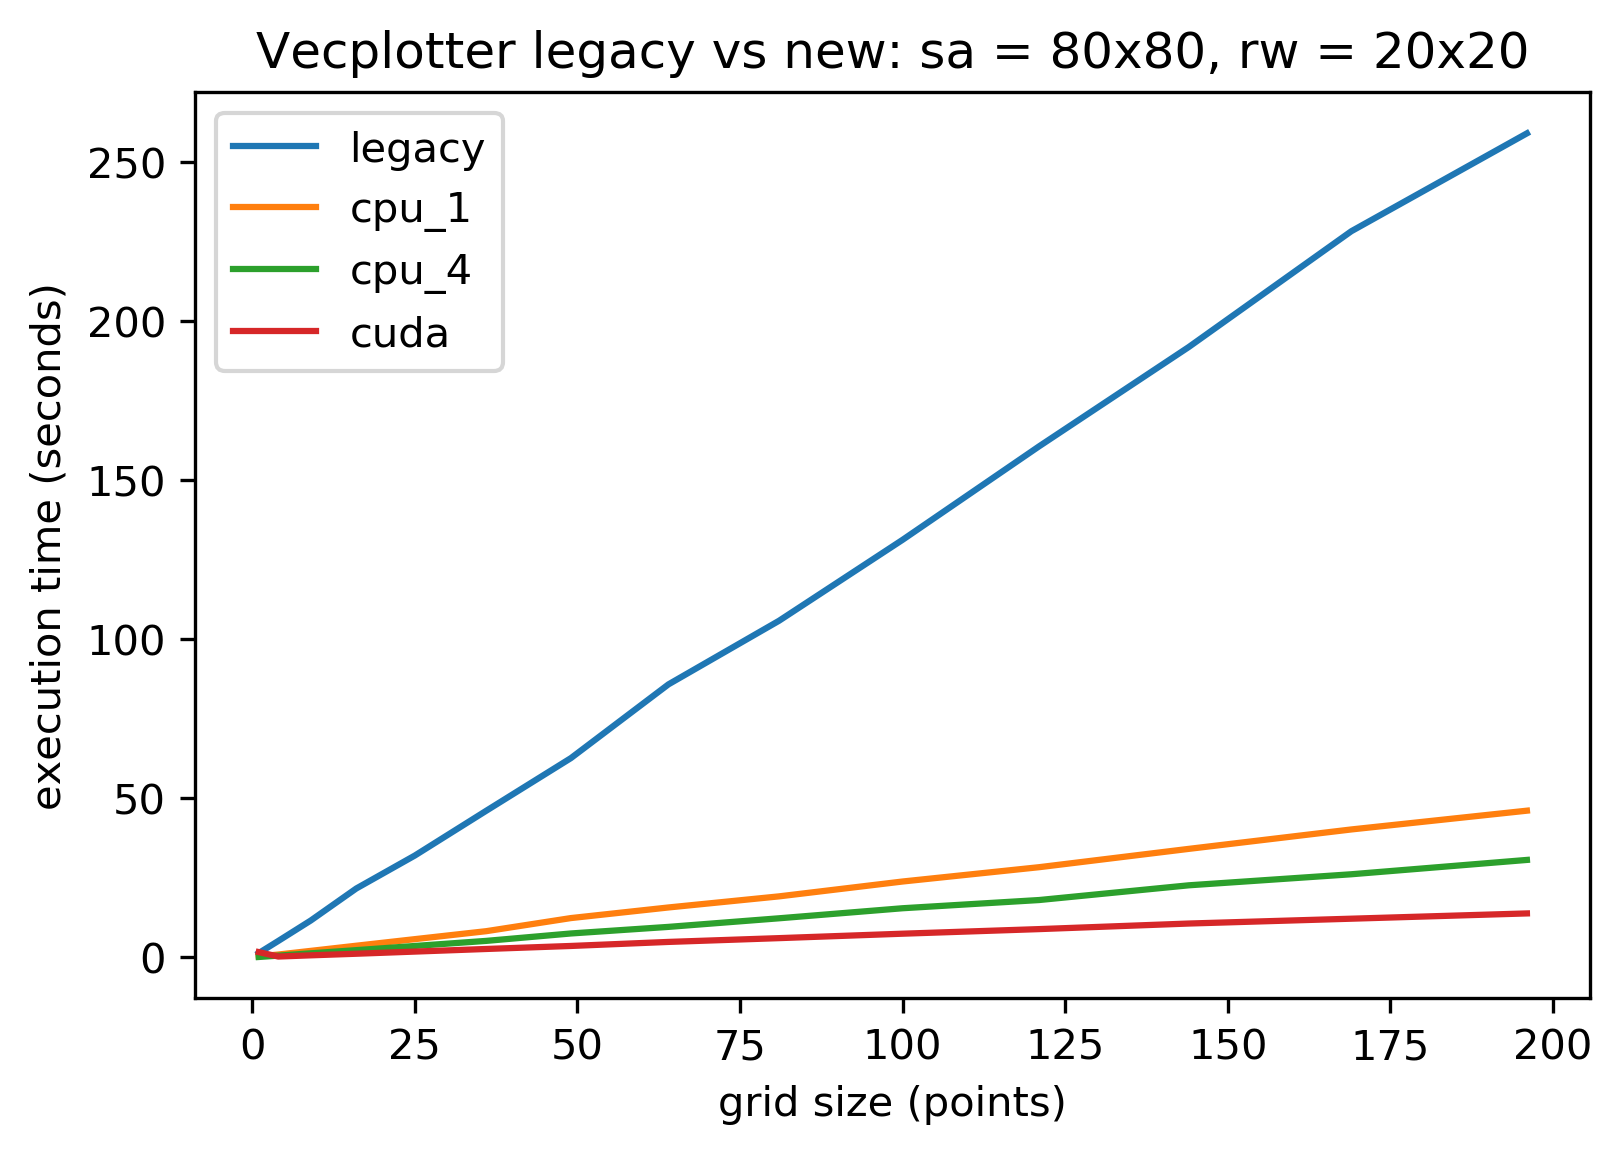

In [9]:
fig = plt.figure(dpi=300)
ax = plt.axes()
nump = [n*n for n in npoints]
ax.plot(nump, times_legacy, label='legacy')
ax.plot(nump, times_cpu_1, label='cpu_1')
ax.plot(nump, times_cpu_4, label='cpu_4')
ax.plot(nump, times_cuda, label='cuda')
ax.legend()
ax.set_title(f'Vecplotter legacy vs new: sa = {sa_cx}x{sa_cy}, rw = {rw_cx}x{rw_cy}')
ax.set_xlabel('grid size (points)')
ax.set_ylabel('execution time (seconds)')
fig.savefig('vecplotter_benchmark.png')

In [10]:
vectors1 = read_result('filtered_output(0).txt')
vectors2 = read_result('filtered_output.txt')

save_vectors_for_glance(vectors1, 'filtered_legacy.vec', color=2, width=3)
save_vectors_for_glance(vectors2, 'filtered_new.vec', color=8, width=2)

for v1, v2 in zip(vectors1, vectors2):
    print(v1)
    print(v2)
    print('='*80)

['144.8011696799', '40.2214180964', '144.8011696799', '40.2412614185', '600', '500', '600', '498', '0.2254134468', '0.2017634720', '3.8625981860']
['144.8011696799', '40.2214180964', '144.8011696799', '40.2412614185', '600', '500', '600', '498', '0.2254134468', '0.2017634720', '3.8625981860']
['144.8011696799', '40.1717843577', '144.8011696799', '40.2313404842', '600', '505', '600', '499', '0.1913829062', '0.6052904159', '3.7339872495']
['144.8011696799', '40.1717843577', '144.8011696799', '40.2313404842', '600', '505', '600', '499', '0.1913829062', '0.6052904159', '3.7339872495']
['144.8011696799', '40.1221142940', '144.7621638315', '40.2313404842', '600', '510', '597', '499', '0.1156011653', '1.1502287622', '3.5308607596']
['144.8011696799', '40.1221142940', '144.7621638315', '40.2313404842', '600', '510', '597', '499', '0.1156011653', '1.1502287622', '3.5308607596']
['144.8011696799', '40.0724079160', '144.6971540841', '40.1717843577', '600', '515', '592', '505', '0.2767537914', '1.